### Imports

In [132]:
from pykeen.pipeline import pipeline
from pykeen.models import TransE
from pykeen.datasets import Nations
from pykeen.datasets import YAGO310

from pykeen.models.predict import get_relation_prediction_df
from pykeen.models.predict import get_all_prediction_df

from pykeen.datasets.analysis import get_relation_count_df
from pykeen.datasets.analysis import get_entity_count_df
#from pykeen.datasets.analysis import get_relation_functionality_df
#from pykeen.datasets.analysis import get_entity_relation_co_occurrence_df
from pykeen.datasets.analysis import get_relation_pattern_types_df

import matplotlib
import matplotlib.pyplot as plt

from collections import Counter

### Exploration

In [68]:
dataset = Nations()

In [69]:
print(dataset)

Nations(num_entities=14, num_relations=55, create_inverse_triples=False)


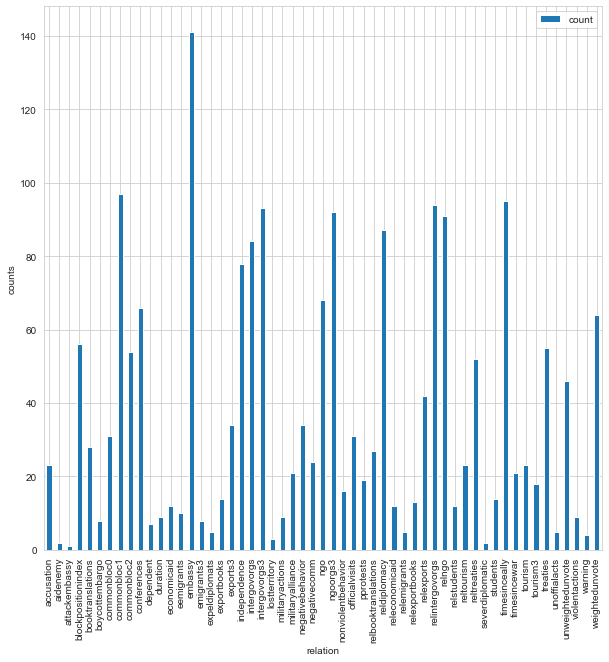

In [105]:
relation_count = get_relation_count_df(dataset)

ax = relation_count.plot.bar(x='relation_label', y='count', rot=90)
ax.set_xlabel("relation")
ax.set_ylabel("counts")

plt.xticks(rotation=90)
plt.rcParams["figure.figsize"]=10,10

    entity_id  count entity_label
0           0    260       brazil
1           1    146        burma
2           2    249        china
3           3    232         cuba
4           4    284        egypt
5           5    302        india
6           6    215    indonesia
7           7    243       israel
8           8    146       jordan
9           9    313  netherlands
10         10    287       poland
11         11    462           uk
12         12    514          usa
13         13    331         ussr


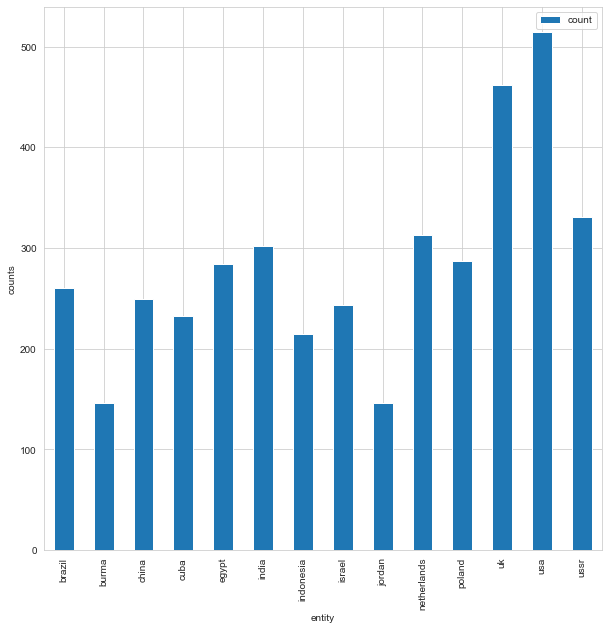

In [106]:
entity_count = get_entity_count_df(dataset)

print(entity_count)

ax = entity_count.plot.bar(x='entity_label', y='count', rot=90)
ax.set_xlabel("entity")
ax.set_ylabel("counts")

plt.xticks(rotation=90)
plt.rcParams["figure.figsize"]=10,10

In [130]:
relation_pattern = get_relation_pattern_types_df(dataset)

relation_pattern['pattern'].value_counts()


INFO:pykeen.datasets.analysis:Loaded 3642 precomputed relational patterns from file:///C:/Users/Tommy%20Lohn/.data/pykeen/datasets/nations/relation_patterns_129e72a2b34ab275.tsv.xz


composition      57
symmetry         13
anti-symmetry    10
inversion         9
Name: pattern, dtype: int64

### Loading TransE

In [131]:
from pykeen.pipeline import pipeline
pipeline_result = pipeline(
    dataset= dataset,
    model= TransE,
    training_loop='sLCWA',
    negative_sampler='basic',
    evaluator='RankBasedEvaluator',
    result_tracker='mlflow',
    result_tracker_kwargs=dict(
        tracking_uri='http://localhost:5000',
        experiment_name='Training of TransE on Nations',
    ),
    device='cpu'
)
#pipeline_result.save_to_directory(r'C:\Users\tommy\OneDrive\Documenten\year 3\Bachelor AI Project\coding')

2022/04/26 00:20:24 INFO mlflow.tracking.fluent: Experiment with name 'Training of TransE on Nations' does not exist. Creating a new experiment.
INFO:pykeen.pipeline.api:Using device: cpu
E:\AnacondaPython\envs\Thesis\lib\site-packages\pykeen\nn\representation.py:372: UserWarning: Directly use Embedding.max_id instead of num_embeddings.
  warnings.warn(f"Directly use {self.__class__.__name__}.max_id instead of num_embeddings.")
Training epochs on cpu: 100%|██████████| 5/5 [00:01<00:00,  2.87epoch/s, loss=0.00618, prev_loss=0.00598]
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
Evaluating on cpu: 100%|██████████| 201/201 [00:00<00:00, 8.73ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


In [23]:
print(pipeline_result)

PipelineResult(random_seed=1005430372, model=TransE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (regularizer): NoRegularizer()
  (entity_embeddings): Embedding(
    (_embeddings): Embedding(14, 50)
  )
  (relation_embeddings): Embedding(
    (_embeddings): Embedding(55, 50)
  )
), training=TriplesFactory(num_entities=14, num_relations=55, num_triples=1592, inverse_triples=False, path="E:\AnacondaPython\envs\Thesis\Lib\site-packages\pykeen\datasets\nations\train.txt"), training_loop=<pykeen.training.slcwa.SLCWATrainingLoop object at 0x000001DFE963D030>, losses=[0.006614661770849371, 0.006457561299429467, 0.006209500770473001, 0.005980261681067883, 0.006170327938980793], metric_results=<pykeen.evaluation.rank_based_evaluator.RankBasedMetricResults object at 0x000001DFEF9F5C30>, train_seconds=0.6205625534057617, evaluate_seconds=0.028025388717651367, stopper=<pykeen.stoppers.stopper.NopStopper object at 0x000001DFEFA3FA60>, configuration={'dataset': 'nations', 'dat

In [65]:
dataset = Nations()

In [67]:
mapped_triples = dataset.testing.mapped_triples

(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>,
        <AxesSubplot:title={'center':'Entity/Relation Plot using PCA'}>],
       dtype=object))

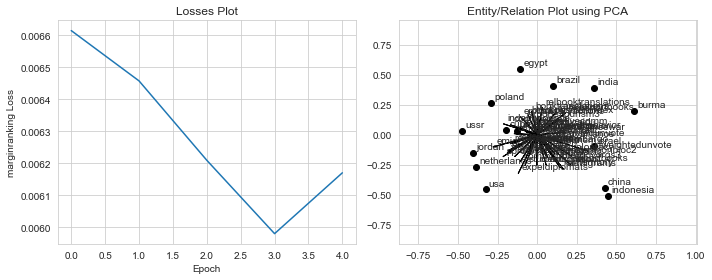

In [24]:
pipeline_result.plot()

### Loading Link Prediction Model

In [25]:
df = get_relation_prediction_df(pipeline_result.model, 'brazil', 'uk', triples_factory=pipeline_result.training)


In [42]:
print(pipeline_result.training)

TriplesFactory(num_entities=14, num_relations=55, num_triples=1592, inverse_triples=False, path="E:\AnacondaPython\envs\Thesis\Lib\site-packages\pykeen\datasets\nations\train.txt")


In [26]:
df.head()

,relation_id,relation_label,score,in_training
44,44,students,-8.007387,False
11,11,duration,-8.261356,False
6,6,commonbloc0,-8.427324,False
30,30,officialvisits,-8.681540,False
5,5,boycottembargo,-8.714373,False


In [27]:
print(df[['relation_label', 'score']])

         relation_label      score
44             students  -8.007387
11             duration  -8.261356
6           commonbloc0  -8.427324
30       officialvisits  -8.681540
5        boycottembargo  -8.714373
45        timesinceally  -8.732647
24     militaryalliance  -8.737715
53              warning  -8.869370
9           conferences  -8.965463
39               relngo  -9.067242
33         reldiplomacy  -9.133108
16       expeldiplomats  -9.316208
41           reltourism  -9.344902
54       weightedunvote  -9.363571
3    blockpositionindex  -9.401876
22        lostterritory  -9.418034
31            pprotests  -9.491055
2         attackembassy  -9.517437
12          economicaid  -9.539150
47              tourism  -9.540081
46         timesincewar  -9.573182
18             exports3  -9.584148
15           emigrants3  -9.604342
0            accusation  -9.686899
35         relemigrants  -9.802209
40          relstudents  -9.861785
32  relbooktranslations  -9.877009
8           commonbl

In [48]:
top_df = get_all_prediction_df(pipeline_result.model, k=10780, triples_factory=pipeline_result.training)

scoring: 100%|██████████| 770/770 [00:00<00:00, 4.47kbatch/s]


In [49]:
top_df.iloc[::-1]

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score,in_training
10779,7,israel,50,unoffialacts,13,ussr,-13.384609,False
10778,2,china,51,unweightedunvote,10,poland,-12.913337,False
10777,8,jordan,12,economicaid,2,china,-12.672441,False
10776,13,ussr,15,emigrants3,1,burma,-12.655348,False
10775,10,poland,0,accusation,0,brazil,-12.638798,False
...,...,...,...,...,...,...,...,...
4,2,china,12,economicaid,2,china,-5.611861,False
3,0,brazil,12,economicaid,0,brazil,-5.611861,False
2,7,israel,12,economicaid,7,israel,-5.611861,False
1,9,netherlands,12,economicaid,9,netherlands,-5.611861,False


In [47]:
print(top_df[['head_label', 'relation_label', 'tail_label', 'score', 'in_training']])

    head_label      relation_label tail_label     score  in_training
0       poland         economicaid     poland -5.611860        False
1    indonesia         economicaid  indonesia -5.611861        False
2         ussr         economicaid       ussr -5.611861        False
3       brazil         economicaid     brazil -5.611861        False
4        china         economicaid      china -5.611861        False
..         ...                 ...        ...       ...          ...
995     brazil         relstudents      india -8.181749        False
996      india  nonviolentbehavior      burma -8.181930        False
997      burma    unweightedunvote      china -8.184084        False
998      egypt         exportbooks       cuba -8.184822        False
999       cuba         relstudents     poland -8.186604        False

[1000 rows x 5 columns]


In [30]:
set(top_df['head_label']).intersection(top_df['tail_label'])

{'brazil',
 'burma',
 'china',
 'cuba',
 'egypt',
 'india',
 'indonesia',
 'israel',
 'jordan',
 'netherlands',
 'poland',
 'uk',
 'usa',
 'ussr'}

In [31]:
list(set(top_df['head_label']) - set(top_df['tail_label']))

[]

### Assuming links as true or false

In [32]:
print(Nations)

<class 'pykeen.datasets.nations.Nations'>
